# Caretta Lab Ferroelectric Testing Notebook

Written by Alexander Qualls (alexander_qualls@brown.edu) on 12/18/2024

This python notebook provides an interrective interface with the ferroelectic (FE) testing functionality avaliable in the open source Python Integrated Experiment Control (piec) package. Currently implemented tests are triangle-wave hysteresis (hyst) and a three-pulse, PUND type measurment (3pp). Code documentation and setupt details can be found at https://piec.readthedocs.io.

*COPY THIS NOTEBOOK AND RUN IN A LOCAL DIRECTORY TO PREVENT IT FROM BEING OVERWRITTEN BY GITHUB*

### Imports

In [1]:
from piec.drivers.Virtual.virtual_awg import VirtualAwg
from piec.drivers.Virtual.virtual_scope import VirtualScope
from piec.measurement_waveforms.discrete_waveform import HysteresisLoop, ThreePulsePund
from piec.analysis.utilities import standard_csv_to_metadata_and_data

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

Warning, if using digilent please check the readme file and install the required dependencies (UL) or try running pip install mcculw


### Instrument Setup

Every FE testing experiment needs an Arbitrary Waveform Generator (awg) and an Oscilloscope (osc) intstrument to apply voltage waveforms and capture voltage response, respectively. In piec these are each represented by a class object. These class objects need to be initialized, making sure the relevant system information is passed (ie GPIB adress). Also make sure relevant supporting software is installed to facilitate instrument interfacing. Most bases are covered by this National Instruments driver https://www.ni.com/en/support/downloads/drivers/download.ni-488-2.html#544048.

In [2]:
awg = VirtualAwg() # 'GPIB0::8::INSTR' for lab awg, 'VIRTUAL' to run in virtual mode
osc = VirtualScope() # 'GPIB0::7::INSTR' for lab scope, 'VIRTUAL' to run in virtual mode
print('AWG: ', awg.idn()) # make sure the selected instruments are what they should be
print('OSC: ', osc.idn())

AWG:  Virtual AWG
OSC:  Virtual Oscilloscope


### Hysteresis

The hyst measurment will apply a simple triangle wave to the sample. The voltage response can be integrated to get the classic polarization hysteresis loop. This response will include the hysteretic FE response, but also the linear dielectric (DE) response and the constant leakage/resistive response.

As a general note aboout these measurements: the captured waveform will often be OFFSET IN TIME from the trigger. As such, we need to determine this time offset (approximately the cable length difference between the measurment cable and the trigger cable / the speed of light) an correct for it to accurately integrate the signal. This is handled automatically by default but BE CAREFUL becasue this automatic shift may FAIL, especially for leaky samples, and may give you nonsensical/misleading results.

In [3]:
### VARIABLE DEFINITIONS ###

path = r"C:\Users\rohan\Dropbox\Documents\Caretta_Lab\modeling_project\DEV_INTEGRATION\data" # path to save data, make sure directory exists and you have permissions

voltage = 1.5 # voltage amplitude of the applied triangle wave (V)
frequency = 1.0e6 # frequency of the applied triangle wave (Hz)
voltage_scale = 0.01 # scale of one y division on the oscilloscope (V), needs to be small enough to be sensitive to the response, but not so small that the signal clips
n_cycles = 2 # how many full voltage cycles to apply, it is good to have at least two to check that successive loops are giving the same response

area = 3.14*(5e-6)**2 # area of the measured capacitor (m^2), used to convert from charge to polarization

time_offset = 1.5e-7 # time between the trigger and the start of the voltage response (s), not used if automatic_timeshift=True

show_plots = True
save_plots = True
automatic_timeshift = False

Capturing waveform of type hysteresis for 1e-06 seconds...
Getting waveform for channel: 1
Applying waveform to virtual sample...
Waveform captured.
Waveform data saved to C:\Users\rohan\Dropbox\Documents\Caretta_Lab\modeling_project\DEV_INTEGRATION\data\28_hysteresis_1p5V_1000000Hz.csv


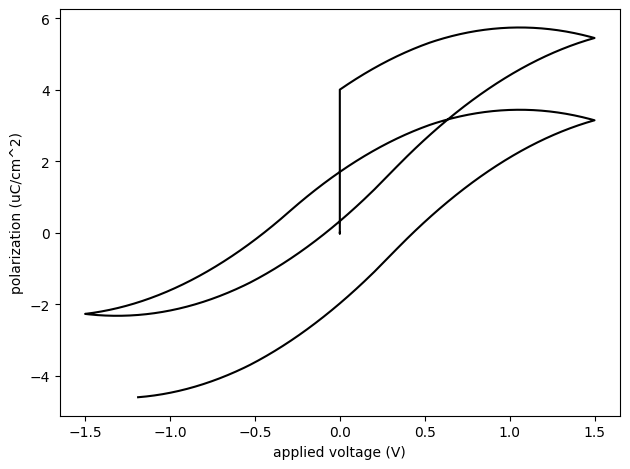

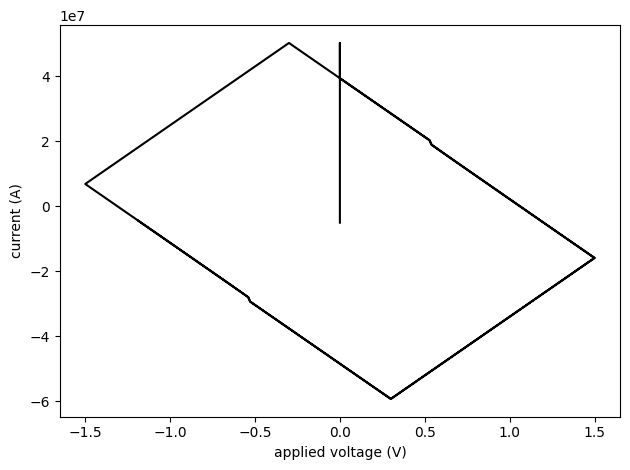

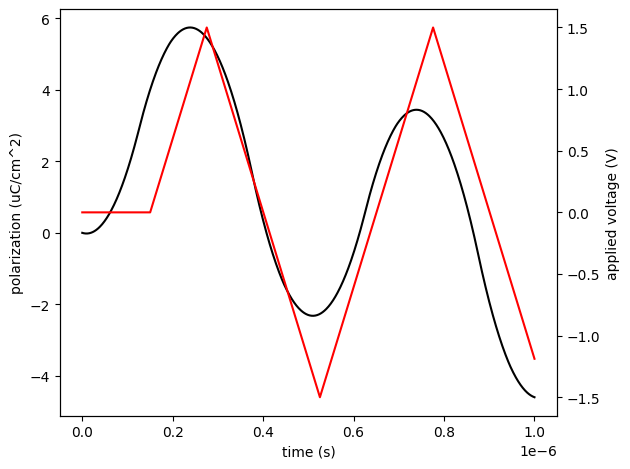

Analysis succeeded, updated C:\Users\rohan\Dropbox\Documents\Caretta_Lab\modeling_project\DEV_INTEGRATION\data\28_hysteresis_1p5V_1000000Hz.csv


In [4]:
### RUN ###

experiment = HysteresisLoop(awg, osc, # initialize the experiment object with specified attributes
                            amplitude=voltage, frequency=frequency,
                            v_div=voltage_scale, n_cycles=n_cycles,
                            area=area, time_offset=time_offset,
                            show_plots=show_plots, save_plots=save_plots,
                            save_dir=path, auto_timeshift=automatic_timeshift)

# run the experiment, this will save raw data in the specified directory, update the raw data with analysis, and generate plots
experiment.run_experiment()

In [5]:
# This cell retrieves the data you just acquired and gives you a dict containing the metadata and a dataframe containing the analyzed response
# Conduct further analysis to your heart's content...
hyst_metadata, hyst_df = standard_csv_to_metadata_and_data(experiment.filename)
hyst_df.head()

,time (s),voltage (V),current (A),polarization (uC/cm^2),applied voltage (V)
0,0.000000e+00,-0.000021,-5.118629e+06,0.000000,0.0
1,1.001001e-09,0.000038,-3.635838e+06,-0.004382,0.0
2,2.002002e-09,0.000054,-3.205068e+06,-0.007805,0.0
3,3.003003e-09,0.000072,-2.767684e+06,-0.010795,0.0
4,4.004004e-09,0.000089,-2.336941e+06,-0.013350,0.0


### Three-Pulse PUND

The 3pp measurment will apply a negative 'reset' pulse to initialize the polarization state of the sample, followed by two identical positive pulses to probe the FE response. The first 'P pulse' will induce an FE, DE, and leakage response similarly to the hyst experiment. The second 'U pulse' however will (nominally) induce an identical DE and leakage response, but no FE response becasue of the FE's hysteretic quality. The response from the second pulse can be subtracted from the first to get the pure remnant FE response. We perform integration and area correction to get a time vs polarization curve, the slope and max value which will be sensitive to the voltage of the P and U pulses.

Time offset correction is still relevant here but the automatic detection is much more relizable becasue of the sharp response peaks that are characteristic of pulsed measurments.

In [8]:
### VARIABLE DEFINITIONS ###

path = r"C:\Users\rohan\Dropbox\Documents\Caretta_Lab\modeling_project\DEV_INTEGRATION\data" # path to save data, make sure directory exists and you have permissions

reset_voltage = 2.0 # voltage amplitude of the negative reset pulse (V), this should be large enough to saturate the FE response
reset_pulsewidth = 1.0e-7 # width of the reset pulse (s)
reset_pulsedelay = 1.0e-7 # delay between reset and measurment pulses (s)

measurement_voltage = 2.0 # voltage amplitude of the measurement pulses (V)
measurement_pulsewidth = 1.0e-7 # width of the measurement pulse (s)
measurement_pulsedelay = 1.0e-7 # delay between the two measurement pulses (s)

voltage_scale = 0.01 # scale of one y division on the oscilloscope (V), needs to be small enough to be sensitive to the response, but not so small that the signal clips

area = 3.14*(5e-6)**2 # area of the measured capacitor (m^2), used to convert from charge to polarization

time_offset = 1.5e-7 # time between the trigger and the start of the voltage response (s), not used if automatic_timeshift=True

show_plots = True
save_plots = True
automatic_timeshift = False

AWG configured for a PUND pulse.
Capturing waveform of type 3pulsepund for 6e-07 seconds...
Getting waveform for channel: 1
Applying waveform to virtual sample...
in get data of virtual scope
here are the voltages:  [-1.44018654e-03 -1.44018654e-03 -1.44018654e-03 -1.44018654e-03
 -1.44018654e-03 -1.44018654e-03 -1.44018654e-03 -1.44018654e-03
 -1.44018654e-03 -1.44018654e-03 -1.44018654e-03 -1.44018654e-03
 -1.44018654e-03 -1.44018654e-03 -1.44018654e-03 -1.44018654e-03
 -1.44018654e-03 -1.44018654e-03 -1.44018654e-03 -1.44018654e-03
 -1.44018654e-03 -1.44018654e-03 -1.44018654e-03 -1.44018654e-03
 -1.44018654e-03 -1.44018654e-03 -1.44018654e-03 -1.44018654e-03
 -1.44018654e-03 -1.44018654e-03 -1.44018654e-03 -1.44018654e-03
 -1.44018654e-03 -1.44018654e-03 -1.44018654e-03 -1.44018654e-03
 -1.44018654e-03 -1.44018654e-03 -1.44018654e-03 -1.44018654e-03
 -1.44018654e-03 -1.44018654e-03 -1.44018654e-03 -1.44018654e-03
 -1.44018654e-03 -1.44018654e-03 -1.44018654e-03 -1.44018654e-03
 -1.

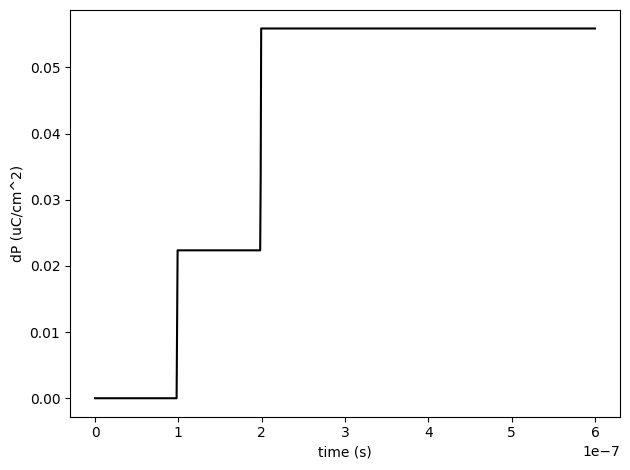

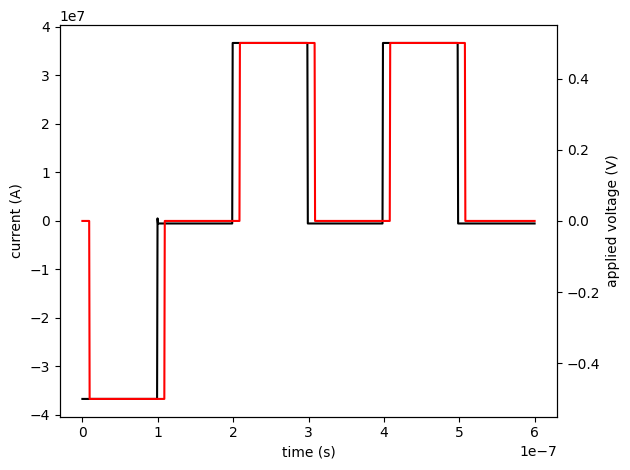

Analysis succeeded, updated C:\Users\rohan\Dropbox\Documents\Caretta_Lab\modeling_project\DEV_INTEGRATION\data\1_3pulsepund_2p0Vres_2p0Vpu.csv


In [9]:
### RUN ###

experiment = ThreePulsePund(awg, osc, # initialize the experiment object with specified attributes
                            reset_amp=reset_voltage, reset_delay=reset_pulsedelay, reset_width=reset_pulsewidth,
                            p_u_amp=measurement_voltage, p_u_delay=measurement_pulsedelay, p_u_width=measurement_pulsewidth,
                            v_div=voltage_scale, area=area,
                            show_plots=show_plots, save_plots=save_plots,
                            save_dir=path, auto_timeshift=automatic_timeshift)

# run the experiment, this will save raw data in the specified directory, update the raw data with analysis, and generate plots
experiment.run_experiment()

In [ ]:
# This cell retrieves the data you just acquired and gives you a dict containing the metadata and a dataframe containing the analyzed response
# Conduct further analysis to your heart's content...
pund_metadata, pund_df = standard_csv_to_metadata_and_data(experiment.filename)
pund_df.head()

### Experiment Example: 'Pulsed Hysteresis'

The basics have been covered, the rest is up to you! Now that you have these experiment objects you can go crazy making custom routines and analysis... We provide as an example a classic voltage dependant polarization experiment that performs many 3pp pulses at different voltages to extract the pure FE response as a function of voltage. This is easy to do in the piec framework: we just stick the 3pp experiment object in a for loop, update the relevant attributes, and run.

In [ ]:
### VARIABLE DEFINITIONS ###

directory = r"\\files22.brown.edu\Research\ENG_Caretta_Shared\Group\probe_station\sz10nmHZO" # path to save data, make sure directory exists and you have permissions

measurement_voltage_start = 0.0 # lowest measurement pulse amplitude to measure (V)
measurement_voltage_stop = 2.0 # highest measurement pulse amplitude to measure (V)
measurement_voltage_step = 0.2 # difference between successive 3pp measurement pulses (V)

measurement_pulsewidth = 1.0e-7 # width of the measurement pulse (s)
measurement_pulsedelay = 1.0e-7 # delay between the two measurement pulses (s)

reset_voltage = 2.0 # voltage amplitude of the negative reset pulse (V), this should be large enough to saturate the FE response
reset_pulsewidth = 1.0e-7 # width of the reset pulse (s)
reset_pulsedelay = 1.0e-7 # delay between reset and measurment pulses (s)

voltage_scale = 0.01 # scale of one y division on the oscilloscope (V), needs to be small enough to be sensitive to the response, but not so small that the signal clips

area = 3.14*(5e-6)**2 # area of the measured capacitor (m^2), used to convert from charge to polarization

time_offset = 1.5e-7 # time between the trigger and the start of the voltage response (s), not used if automatic_timeshift=True

show_plots = False
save_plots = True
automatic_timeshift = True

In [ ]:
### RUN ###

experiment = ThreePulsePund(awg, osc, # initialize the experiment object with specified attributes
                                reset_amp=reset_voltage, reset_delay=reset_pulsedelay, reset_width=reset_pulsewidth,
                                p_u_delay=measurement_pulsedelay, p_u_width=measurement_pulsewidth,
                                v_div=voltage_scale, area=area, save_dir=directory)

for measurement_voltage in np.arange(measurement_voltage_start, measurement_voltage_stop, measurement_voltage_step): # for loop over voltage
    experiment.p_u_amp = measurement_voltage # update measument voltage attribute
    experiment.run_experiment() # run the experiment, this will save raw+analyzed data+plots in the specified directory

Here is some example analysis you could do on such data: plotting polarization vs voltage and fitting to Merz law, making 3D polarization vs time vs voltage plots... I reference some real data here to demonstrate.

In [ ]:
from scipy.optimize import curve_fit

def merz(E, u0=1, alpha=1, Ec=1):
    return u0*np.exp(-alpha/(E))

directory = r'\\files22.brown.edu\Research\ENG_Caretta_Shared\Group\probe_station\sz10nmHZO'

In [ ]:
voltages, polarizations = [], []

# loop over choice directory with V scaling 3pp data
for file in os.listdir(directory): 
    if '.csv' in file:
        metadata, data = standard_csv_to_metadata_and_data(os.path.join(directory, file)) # read data with helper function
        if metadata['type'].values[0] == '3PP': # we can leverage the metadata to filter for just the type of experiments we want
            voltage = metadata['p_u_amp'].values[0]
            voltages.append(voltage)
            polarizations.append(data['dP (uC/cm^2)'].values[50])

# fit to some physical models! why not? science!        
popt, _ = curve_fit(merz, voltages, polarizations,) 

x_fit = np.linspace(min(voltages), max(voltages), 100)
y_fit = merz(x_fit, *popt)

# make pretty plots! The world is your oyster!
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(voltages, polarizations, 'ko', label='data')
ax.plot(x_fit, y_fit, 'r-', label='Merz Law Fit')
ax.set_xlabel('$Voltage (V)$')
ax.set_ylabel('$2P_r (\mu C/cm^2)$') 
ax.legend()
ax.set_title(directory.split('\\')[-1])
plt.show()

In [ ]:
voltages = []
time_data = []
polarization_data = []

# Iterate through CSV files in the directory
for file in os.listdir(directory):
    if '.csv' in file:
        metadata, data = standard_csv_to_metadata_and_data(os.path.join(directory, file)) # read data with helper function
        if metadata['type'].values[0] == '3PP': # we can leverage the metadata to filter for just the type of experiments we want

            voltage = metadata['p_u_amp'].values[0]
            time = data['time (s)'].values
            polarization = data['dP (uC/cm^2)'].values

            voltages.append(voltage)
            time_data.append(time)
            polarization_data.append(polarization)

# Sort data by voltage
sorted_indices = np.argsort(voltages)
voltages = np.array(voltages)[sorted_indices]
time_data = [time_data[i] for i in sorted_indices]
polarization_data = [polarization_data[i] for i in sorted_indices]

# Create 2D grid for contour plot
unique_times = np.unique(np.concatenate(time_data))
time_grid, voltage_grid = np.meshgrid(unique_times, voltages)

# Interpolate polarization data onto grid
polarization_grid = np.zeros_like(time_grid)
for i, (time, polarization) in enumerate(zip(time_data, polarization_data)):
    polarization_grid[i, :] = np.interp(unique_times, time, polarization)

# Plot contour
plt.figure(figsize=(4,3))
contour = plt.contourf(voltage_grid, time_grid, polarization_grid, levels=50, cmap='viridis')
plt.colorbar(contour, label='$2P_r (\mu C/cm^2)$')
plt.xlabel('$Voltage (V)$')
plt.ylabel('$Time (s)$')
plt.show()
